In [394]:
#Data manipulation
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

#Visualization & Graphic EDA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer
from sklearn.model_selection import train_test_split

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import learning_curve, ShuffleSplit

#Assessment
from sklearn.metrics import accuracy_score, classification_report, roc_curve


# About data

Census data (age, education, country etc.), the goal is to predict whether a person makes over 50K $ a year. Raw dataset and its description can be found at UCI Machine Learning Repository (link below).

https://archive.ics.uci.edu/ml/datasets/adult

In [395]:
#Let's load it
data = pd.read_hdf('/home/grzeszo/Downloads/train.adult.h5')

In [396]:
#what we have here...
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [397]:
#more precisely about missing data
data.isnull().any()

Age               False
Workclass          True
fnlwgt            False
Education         False
Education-Num     False
Martial Status    False
Occupation         True
Relationship      False
Race              False
Sex               False
Capital Gain      False
Capital Loss      False
Hours per week    False
Country            True
Target            False
dtype: bool

In [398]:
#some descripitve stats - helpful for numeric data, for non-numeric we should try something else
data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,423.516600,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,3363.342471,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,-31441.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,27828.000000,4356.000000,99.000000


In [399]:
#how many values
data.apply(lambda x: x.nunique())

Age                  73
Workclass             8
fnlwgt            21648
Education            16
Education-Num        16
Martial Status        7
Occupation           14
Relationship          6
Race                  5
Sex                   2
Capital Gain        119
Capital Loss         92
Hours per week       94
Country              41
Target                2
dtype: int64

In [400]:
#what values?
data.select_dtypes(['object','bool']).apply(lambda x: x.value_counts()).T.stack()
#data.select_dtypes(['object','bool']).mode()

Workclass       Federal-gov                     960.0
                Local-gov                      2093.0
                Never-worked                      7.0
                Private                       22696.0
                Self-emp-inc                   1116.0
                Self-emp-not-inc               2541.0
                State-gov                      1298.0
                Without-pay                      14.0
Education       10th                            933.0
                11th                           1175.0
                12th                            433.0
                1st-4th                         168.0
                5th-6th                         333.0
                7th-8th                         646.0
                9th                             514.0
                Assoc-acdm                     1067.0
                Assoc-voc                      1382.0
                Bachelors                      5355.0
                Doctorate   

In [401]:
#transform non-numeric data to numeric form 
cat_feats = data.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    data['{0}_cat'.format(cat_feat)] = pd.factorize(data[cat_feat] )[0]

In [402]:
#on the right
data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Workclass_cat,Education_cat,Martial Status_cat,Occupation_cat,Relationship_cat,Race_cat,Country_cat,Target_cat
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,<=50K,0,0,0,0,0,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,<=50K,1,0,1,1,1,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,<=50K,2,1,2,2,0,0,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,<=50K,2,2,1,2,1,1,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,<=50K,2,0,1,3,2,1,1,0


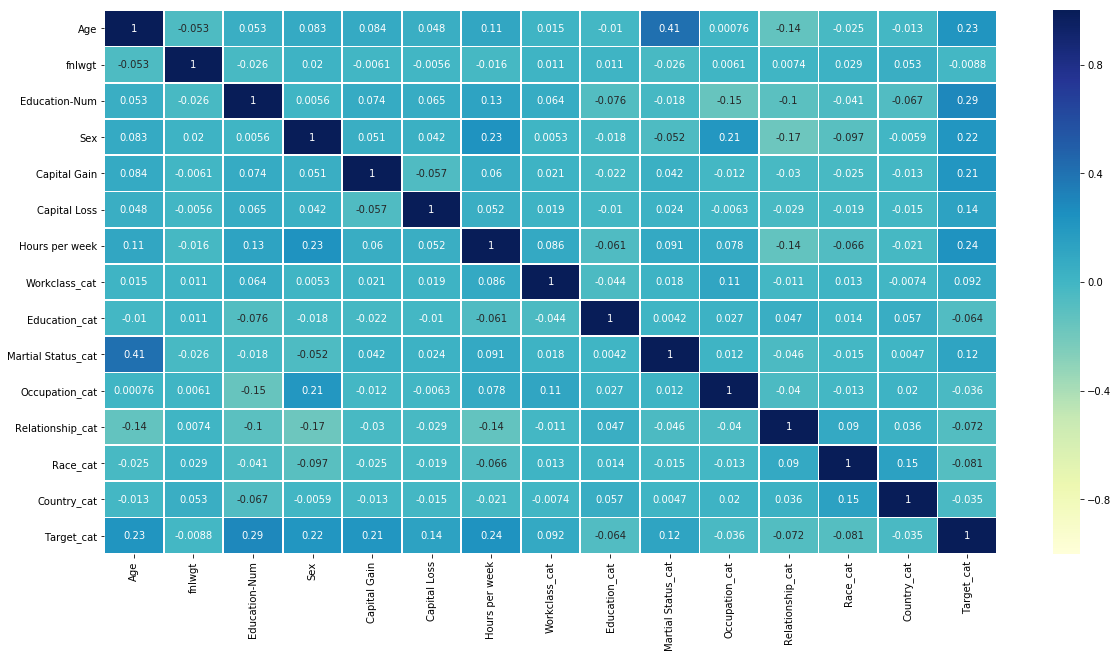

In [403]:
#now we can check correlations for all features

plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(data.corr(method='kendall'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

# Some feature engineering

In [404]:
#probably one will ear less on retirement
data['Retirement'] = (data.Age >= 65).astype(int)

#
data['White_husband'] = ((data.Relationship == 'Husband') & (data.Race == 'White')).astype(int)
data['Black_husband'] = ((data.Relationship == 'Husband') & (data.Race == 'Black')).astype(int)

#Race x sex
data['White_male'] = ((data.Race == 'White') & (data.Sex == False)).astype(int)
data['Black_male'] = ((data.Race =="Black") & (data.Sex == False)).astype(int)

data['White_female'] = ((data.Race == 'White') & (data.Sex == True)).astype(int)
data['Black_female'] = ((data.Race == "Black") & (data.Sex == True)).astype(int)

#well-educated tend to earn more
data['Higher_education'] = (data.Education.isin(['Bachelors','Masters','Doctorate'])).astype(int)

#you'll earn more in US than e.g. Guatemala
data['Rich_country'] = (data.Country.isin(['United-States', 'Germany', 'Japan', 'France', 'England', 'Scotland', 'Canada','Italy','Holand-Netherlands'])).astype(int)

#managers usually earn much more than the rest
data['Is_manager?'] = ((data.Occupation == 'Exec-managerial')).astype(int)

# Threshold for most european countries
data['After_hours'] = ((data['Hours per week']) > 40).astype(int)

#family to feed
data['Spouse'] = ((data.Relationship.isin(['Husband','Wife']))).astype(int) 


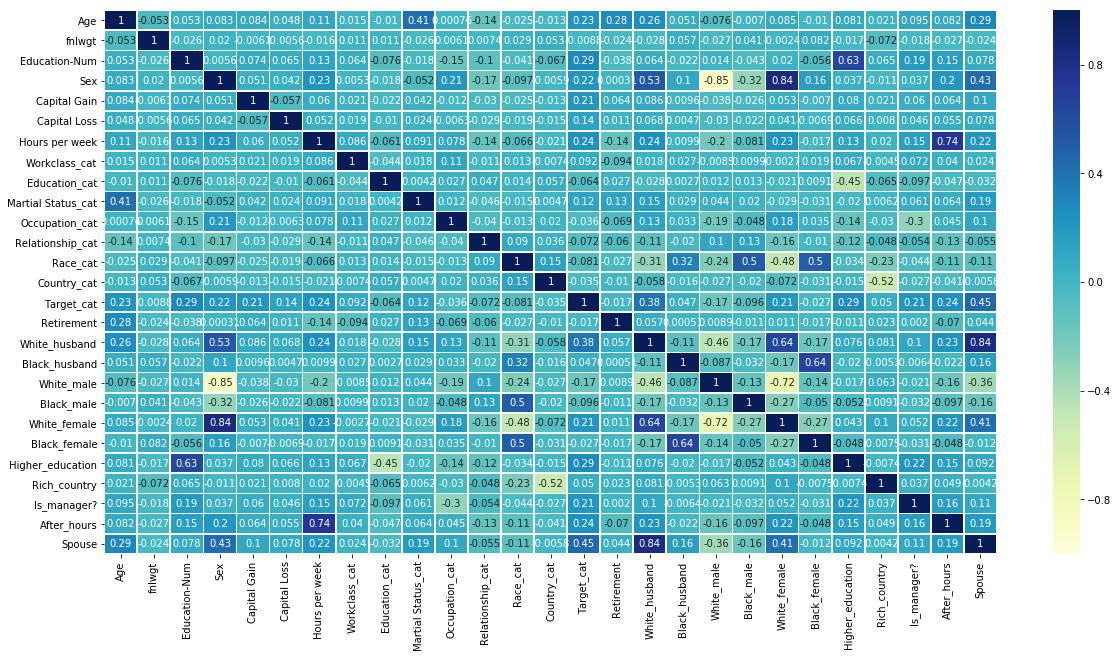

In [405]:
#correlation once again - now we include out new features

plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(data.corr(method='kendall'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

# Buliding our model

In [406]:
#features for our model
feats = data.select_dtypes(include=['int8','int16','int64']).columns.values
feats

array(['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_cat', 'Education_cat',
       'Martial Status_cat', 'Occupation_cat', 'Relationship_cat',
       'Race_cat', 'Country_cat', 'Target_cat', 'Retirement',
       'White_husband', 'Black_husband', 'White_male', 'Black_male',
       'White_female', 'Black_female', 'Higher_education', 'Rich_country',
       'Is_manager?', 'After_hours', 'Spouse'], dtype=object)

In [407]:
#we'll be predicting this
feats = feats[feats!=['Target_cat']]
feats

array(['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_cat', 'Education_cat',
       'Martial Status_cat', 'Occupation_cat', 'Relationship_cat',
       'Race_cat', 'Country_cat', 'Retirement', 'White_husband',
       'Black_husband', 'White_male', 'Black_male', 'White_female',
       'Black_female', 'Higher_education', 'Rich_country', 'Is_manager?',
       'After_hours', 'Spouse'], dtype=object)

In [408]:
X = data[feats]
y = data['Target_cat']

In [409]:
def train_and_predict(model, X, y, test_size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    
    print(classification_report(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

In [410]:
# Pipeline

In [411]:
model = DecisionTreeClassifier(max_depth=10, random_state=123)

In [412]:
pipe = Pipeline([('imputer',Imputer(strategy='most_frequent')),
                 ('scaler', StandardScaler()),
                 ('selector', SelectKBest(f_classif,k=17)),
                 ('CF', model)
                ])

In [413]:
train_and_predict(pipe, X, y, test_size=0.3)

             precision    recall  f1-score   support

          0       0.87      0.95      0.91      7417
          1       0.77      0.57      0.65      2352

avg / total       0.85      0.86      0.85      9769



0.85566588187122528

In [414]:
#Need more data?

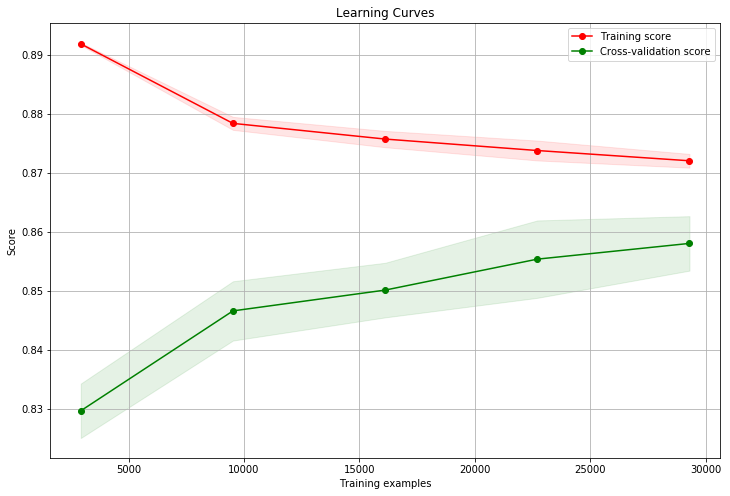

In [415]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


plt = plot_learning_curve(model, "Learning Curves", X, y, cv=10, n_jobs=4)
plt.show()